In [1]:
import torch
from torchinfo import summary
import pandas as pd
import re
from tqdm.notebook import tqdm
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import pymorphy2
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from IPython.display import clear_output

In [2]:
RANDOM_SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForMaskedLM, BertModel
from tqdm import tqdm, trange, tqdm_notebook
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification

In [6]:
def make_sent(s):
    if s == 'positive':
        return 2
    if s == 'negative':
        return 0
    return 1
    

In [7]:
df_REVIEWS = pd.read_csv('rureviews/data.csv', sep='\t', lineterminator='\n', index_col = None)
df_REVIEWS['sentiment'] = df_REVIEWS['sentiment'].apply(lambda s: make_sent(s))

In [8]:
txt, sentiment = list(df_REVIEWS['review']), list(df_REVIEWS['sentiment'])

In [9]:
model_donor = BertModel.from_pretrained("sberbank-ai/ruBert-base")

tmp_directory = 'model_tmp'

model_donor.save_pretrained(tmp_directory)

model = BertForSequenceClassification.from_pretrained(tmp_directory, num_labels=3)
model.cuda()

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [10]:
sentences_bert = ["[CLS] " + sentence + " [SEP]" for sentence in txt]

In [11]:
train_sentences, test_sentences, train_y, test_y = train_test_split(sentences_bert, sentiment, test_size=0.2,random_state=RANDOM_SEED)

In [12]:
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruBert-base")
# base -model | uncased - все слова в нижнем регистре
tokenized_texts_train = [tokenizer.tokenize(sent) for sent in train_sentences]
tokenized_texts_test = [tokenizer.tokenize(sent) for sent in test_sentences]
print(tokenized_texts_train[0])

['[CLS]', 'посылка', 'шла', 'до', 'тю', '##м', '.', 'обл', '.', 'около', 'месяца', '.', 'рубашка', 'пришла', 'маленькая', 'на', '1', 'размер', 'меньше', '.', 'заказала', 'l', 'хотя', 'нашу', 'м', '.', 'и', 'не', 'угадала', 'с', 'размерами', '.', 'очень', 'тесная', 'в', 'груди', '.', 'и', 'после', 'стирки', 'швы', 'стали', 'расходиться', '.', 'по', 'этому', 'сни', '##жаю', 'до', '3', 'звезд', '.', 'не', 'рекомендую', 'товар', '.', '[SEP]']


In [13]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_train]
input_ids = pad_sequences(
    input_ids,
    maxlen=128,
    dtype="long",
    truncating="pre",
    padding="pre"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [14]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_y, 
    random_state=RANDOM_SEED,
    test_size=0.2
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=RANDOM_SEED,
    test_size=0.2
)

In [15]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size= 32
)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size= 32
)

In [16]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

max_grad_norm_clipping = 1

In [17]:
def train(model, train_dataloader, optimizer, EPOCH_AMOUNT, with_clipping=False,max_grad_norm_clipping=1):
    # Будем сохранять loss во время обучения
    # и рисовать график в режиме реального времени
    train_loss_set = []
    train_loss = 0


    # Обучение
    # Переводим модель в training mode
    model.train()

    for _ in range(EPOCH_AMOUNT):
        for step, batch in enumerate(train_dataloader):
          # добавляем батч для вычисления на GPU
            
            batch = tuple(t.to(device) for t in batch)
          # Распаковываем данные из dataloader
            b_input_ids, b_input_mask, b_labels = batch
          
          # если не сделать .zero_grad(), градиенты будут накапливаться
            optimizer.zero_grad()
          
          # Forward pass
            loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

            train_loss_set.append(loss[0].item())  
          
          # Backward pass
            loss[0].backward()

            if with_clipping:
              # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm_clipping)
          
          # Обновляем параметры и делаем шаг используя посчитанные градиенты
            optimizer.step()

          # Обновляем loss
            train_loss += loss[0].item()
          
          # Рисуем график
            clear_output(True)
            plt.figure(figsize=(12, 6))
            plt.plot(train_loss_set)
            plt.title("Training loss")
            plt.xlabel("Batch")
            plt.ylabel("Loss")
            plt.grid()
            plt.show()
          
        print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

In [18]:
def test(model, dataloader, name_dtlder='Test'):
    # Валидация
    # Переводим модель в evaluation mode
    model.eval()
    test_preds, test_labels = [], []

    for batch in tqdm_notebook(dataloader):
        # добавляем батч для вычисления на GPU
        #print(batch[0].shape, batch[1].shape, batch[2].shape)
        batch = tuple(t.to(device) for t in batch)
        
        # Распаковываем данные из dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # При использовании .no_grad() модель не будет считать и хранить градиенты.
        # Это ускорит процесс предсказания меток для тестовых данных.
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Перемещаем logits и метки классов на CPU для дальнейшей работы
        logits = logits[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Сохраняем предсказанные классы и ground truth
        batch_preds = np.argmax(logits, axis=1)

        if len(label_ids.shape) == 1:
            batch_labels = label_ids  
        else:
            batch_labels = np.concatenate(label_ids)
        test_preds.extend(batch_preds)
        test_labels.extend(batch_labels)
        batch_preds = np.argmax(logits, axis=1) 

    
    acc_score = accuracy_score(test_labels, test_preds)
    print('Процент правильных предсказаний на {0} выборке составил:  f1 = {1:.2f}%'.format(name_dtlder, f1_score(test_labels, test_preds, average='macro') * 100
    ))

    return test_preds, test_labels

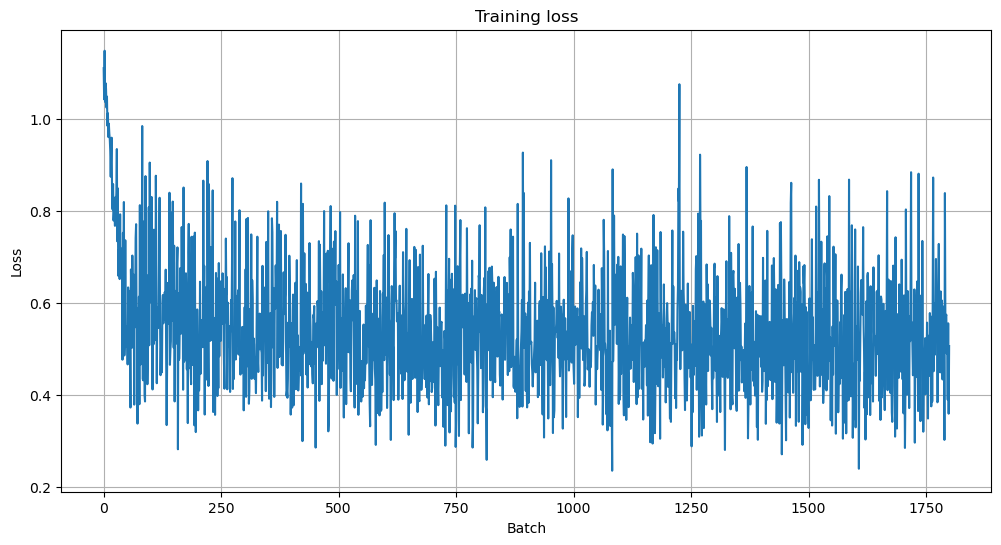

Loss на обучающей выборке: 0.54194


In [19]:
train(model, train_dataloader, optimizer, 1)

In [20]:
val_preds, val_labels = test(model, validation_dataloader, name_dtlder='VAl')
val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
print(classification_report(val_preds, val_labels))

C:\Users\V\AppData\Local\Temp\ipykernel_1340\588143551.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(dataloader):


  0%|          | 0/450 [00:00<?, ?it/s]

Процент правильных предсказаний на VAl выборке составил:  f1 = 77.79%
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      5130
           1       0.69      0.67      0.68      4932
           2       0.86      0.94      0.90      4338

    accuracy                           0.78     14400
   macro avg       0.78      0.78      0.78     14400
weighted avg       0.77      0.78      0.77     14400



In [58]:
df_YT = pd.read_csv('youtube_all_comments.csv')

C:\Users\V\AppData\Local\Temp\ipykernel_1340\3183887844.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_YT = pd.read_csv('youtube_all_comments.csv')


In [59]:
txt, sentiment = list(df_YT['text']), list(df_YT['text'])

In [60]:
txt = ["[CLS] " + sentence + " [SEP]" for sentence in txt]

In [61]:
tokenized_texts_test = [tokenizer.tokenize(sent) for sent in txt]

In [62]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]

input_ids = pad_sequences(
    input_ids,
    maxlen=128,
    dtype="long",
    truncating="pre",
    padding="pre"
)

In [63]:
input_ids.shape

(1646130, 128)

In [64]:
test_y = np.zeros((1646130,))

In [65]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

test_inputs = torch.tensor(input_ids)
test_masks = torch.tensor(attention_masks)
test_labels = torch.tensor(test_y)

test_data = TensorDataset(
    test_inputs,
    test_masks,
    test_labels
)

test_dataloader = DataLoader(
    test_data, 
    sampler=SequentialSampler(test_data),
    batch_size=32
)

In [66]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [67]:
test_preds, test_labels = test(model, test_dataloader, name_dtlder='Test')

C:\Users\V\AppData\Local\Temp\ipykernel_1340\588143551.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(dataloader):


  0%|          | 0/51442 [00:00<?, ?it/s]

Процент правильных предсказаний на Test выборке составил:  f1 = 25.02%


In [68]:
test_labels = np.array(test_labels)
test_preds = np.array(test_preds)

In [69]:
test_preds.shape

(1646130,)

In [70]:
test_preds

array([1, 2, 0, ..., 0, 0, 0], dtype=int64)

In [72]:
df_YT['sentiment'] = test_preds

In [73]:
df_YT.to_csv('comments.csv')